In [33]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import  precision_score, recall_score, f1_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.model import Net as Net
from models.FeedForwardNet.model_3 import Net as Net3
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from utils.EarlyStopping import EarlyStopping


In [34]:
df = pd.read_csv('data/raw/dukecathr.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:

targets = list()
train_losses=[]
train_accu=[]
balanced_accuracy_list = []
precision_list = []
recall_list = []

In [36]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data in tqdm(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

In [37]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25, model_path='models/FeedForwardNet/best_checkpoint.pth'):
    model = model.to(device)  # Move the model to the GPU
    step_size = 50
    gamma = 0.5
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer)
        train_accu.append(accu)
        train_losses.append(train_loss)
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f}')

        # Check if the scheduler is about to step
        if (epoch + 1) % step_size == 0:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step()
            new_lr = optimizer.param_groups[0]['lr']
            print(f'Scheduler step at epoch {epoch + 1}: Learning rate changed from {old_lr} to {new_lr}')
        else:
            scheduler.step()

In [38]:
def evaluate_model(model, dataloader, criterion, target):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs,labels=data[0].to(device),data[1].to(device)
            outputs=model(inputs)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    
    # Calculate metrics
    
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Append the metrics to the lists
    balanced_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)
    targets.append(target)

    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

In [39]:
def process_target(df, target):
   # Step 1: Preprocess the data
   X, y, num_cols, cat_cols = output_selection_prepro(df, target)

   # Split the data into train and test sets
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
   
   Scaler = StandardScaler()
   X_train = Scaler.fit_transform(X_train)
   X_test = Scaler.transform(X_test)
   
   
   # Convert features and labels to tensors
   X_train_tensor = torch.tensor(X_train.astype(np.float32))
   X_test_tensor = torch.tensor(X_test.astype(np.float32))
   y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
   y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

   # Convert the data into PyTorch tensors and load them into a DataLoader
   train_data = TensorDataset(X_train_tensor, y_train_tensor)
   test_data = TensorDataset(X_test_tensor, y_test_tensor)

   batch_size = 2048
   train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
   test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

   # Define the model, loss function, and optimizer
   model = Net3(X.shape[1])
   criterion = nn.BCELoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=0.0009)

   # Train the model
   train_model(model, train_loader, criterion, optimizer, num_epochs=200)
   
   #evaluate the model
   evaluate_model(model, test_loader, criterion, target)
   

In [40]:
all_targets = ['LMST','RCAST','CHFSEV', 'ACS', 'NUMDZV','DEATH',  'LADST', 'LCXST', 'PRXLADST' ]

for target in all_targets:
     balance_accuracy, precision, recall, target = test_model(target)
     targets.append(target)
    #append the metrics to the lists
     balanced_accuracy_list.append(balance_accuracy)
     precision_list.append(precision)
     recall_list.append(recall)


In [41]:
# save the results in a dataframe
results_df = pd.DataFrame({'Target':targets, 'balanced_accuracy':balanced_accuracy_list, 'precision':precision_list, 'recall':recall_list})
results_df

,Target,balanced_accuracy,precision,recall
0,LMST,0.707903,0.168040,0.657534
1,RCAST,0.728868,0.789092,0.829919
2,CHFSEV,0.967065,0.816080,0.986416
3,ACS,0.730514,0.795610,0.719344
4,NUMDZV,0.874500,0.987488,0.887832
5,DEATH,0.937995,0.978241,0.908016
6,LADST,0.700074,0.834180,0.713884
7,LCXST,0.683834,0.746479,0.663203
8,PRXLADST,0.628739,0.422951,0.495146


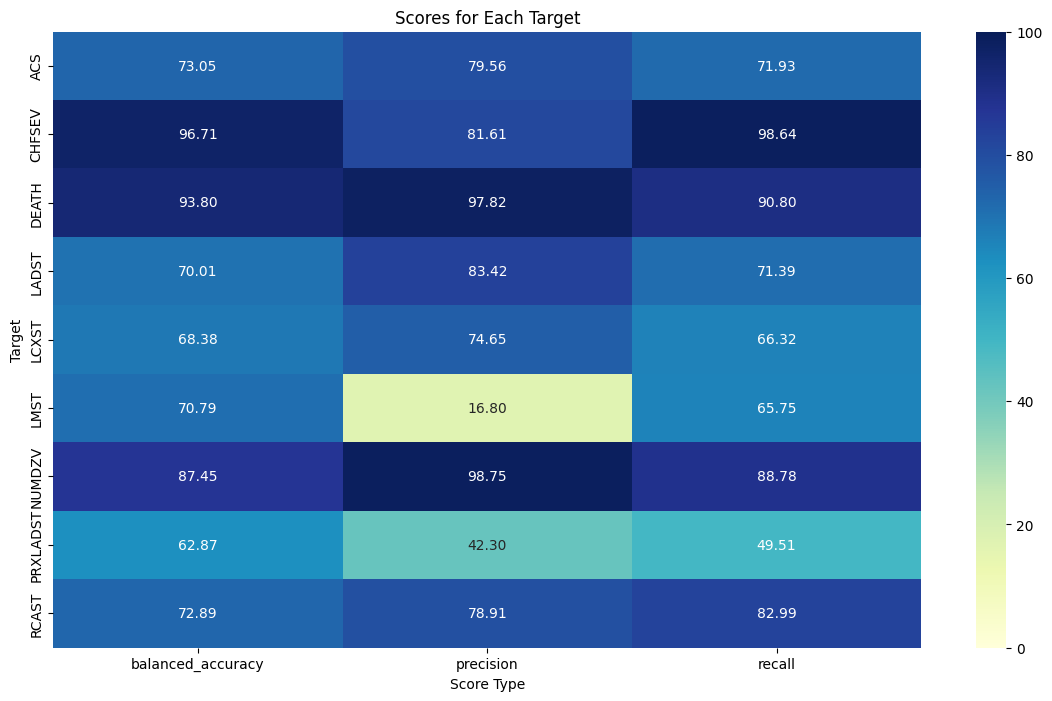

In [42]:
# plot heatmap
plot_heat_map(results_df,separate_graphs=False)

In [43]:
accuracy, precision, recall, balance_accuracy = test_model('models/FeedForwardNet/best_checkpoint.pth', 'RCAST')
print(f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}')

TypeError: test_model() takes 1 positional argument but 2 were given